In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys

## Importing custom functions from different folder:

In [3]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    from utils_data import load_data, data_clustering, plot_data, cleaning_data, linear_transf
    from utils_data import experimental_velocity, plot_velocity, saving_processed_data
    from utils_data import load_processed_data
    from utils_model import numericalSimulation, ComputeFunctional, ComputeVel
    from utils_model import generate_trajectory, plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories, plotting_params
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Loading multiple subjects data

In [4]:
## Loading subject 27
dfx_27_11, dfy_27_11 = load_data( path = 'myData-S27-1-C1.mat' )

KeyError: 'X'

## Functions

In [38]:
import scipy
import os

path = 'myData-S25-1-C1.mat'

# Get the current directory
current_dir = os.getcwd()

# Navigate one step up (to the parent directory)
parent_dir = os.path.dirname(current_dir)

# Enter the 'data' folder
data_folder = os.path.join(parent_dir, 'data')

# Construct the full file path
full_path = os.path.join(data_folder, path)

# Load the data from the file
mat = scipy.io.loadmat(full_path)

In [39]:
# View the keys (variable names) in the .mat file
print(mat.keys())
mat 

dict_keys(['__header__', '__version__', '__globals__', 'dataK', 'tETT'])


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue May 14 17:30:07 2024',
 '__version__': '1.0',
 '__globals__': [],
 'dataK': array([[(array([[291879, 291880, 291881, 291883, 291884, 291885, 291888, 291889,
                 291890, 291891, 291894, 291895, 291897, 291902, 291904, 291905,
                 291906, 291910, 291911, 291912, 291913, 291914, 291916, 291920,
                 291922, 291926, 291935, 291937, 291938, 291939, 291941, 291943,
                 291946, 291947, 291949, 291951, 291954, 291961, 291962, 291963,
                 291964, 291966, 291968, 291972, 291973, 291975, 291976, 291979,
                 291980, 291983, 292634, 292636, 292637, 292638, 292640, 292641,
                 292644, 292645, 292646, 292653, 292655, 292656, 292658, 292660,
                 292662, 292663, 292667, 292670, 292674, 292675, 292676, 292677,
                 292678, 292682, 292686, 292687, 292689, 292695, 292696, 292697,
                 292698, 292699, 292700, 2

In [40]:
print('DataK:')
print(type(mat["dataK"]))
print(len(mat["dataK"]))
print('DataK [0][0]')
dataK = mat["dataK"][0][0] 
print(type(dataK))
print(len(dataK))
print(dataK)


DataK:
<class 'numpy.ndarray'>
1
DataK [0][0]
<class 'numpy.void'>
4
(array([[291879, 291880, 291881, 291883, 291884, 291885, 291888, 291889,
        291890, 291891, 291894, 291895, 291897, 291902, 291904, 291905,
        291906, 291910, 291911, 291912, 291913, 291914, 291916, 291920,
        291922, 291926, 291935, 291937, 291938, 291939, 291941, 291943,
        291946, 291947, 291949, 291951, 291954, 291961, 291962, 291963,
        291964, 291966, 291968, 291972, 291973, 291975, 291976, 291979,
        291980, 291983, 292634, 292636, 292637, 292638, 292640, 292641,
        292644, 292645, 292646, 292653, 292655, 292656, 292658, 292660,
        292662, 292663, 292667, 292670, 292674, 292675, 292676, 292677,
        292678, 292682, 292686, 292687, 292689, 292695, 292696, 292697,
        292698, 292699, 292700, 292701, 292702, 292703, 292704, 292705,
        292706, 292709, 292711, 292713, 292715, 292716, 292717, 292720,
        292721, 292723, 292724, 292725, 292726, 292727, 292728, 29

In [41]:
print('DataK[0][0] [0]')
print(type(dataK[0]))
print(len(dataK[0]))
print(dataK[0])
print('DataK[0][0] [0][0]')
print(type(dataK[0][0]))
print(len(dataK[0][0]))
print(dataK[0][0])


DataK[0][0] [0]
<class 'numpy.ndarray'>
1
[[291879 291880 291881 291883 291884 291885 291888 291889 291890 291891
  291894 291895 291897 291902 291904 291905 291906 291910 291911 291912
  291913 291914 291916 291920 291922 291926 291935 291937 291938 291939
  291941 291943 291946 291947 291949 291951 291954 291961 291962 291963
  291964 291966 291968 291972 291973 291975 291976 291979 291980 291983
  292634 292636 292637 292638 292640 292641 292644 292645 292646 292653
  292655 292656 292658 292660 292662 292663 292667 292670 292674 292675
  292676 292677 292678 292682 292686 292687 292689 292695 292696 292697
  292698 292699 292700 292701 292702 292703 292704 292705 292706 292709
  292711 292713 292715 292716 292717 292720 292721 292723 292724 292725
  292726 292727 292728 292729 292730 292731 292734 292735 292736 292737
  292738]]
DataK[0][0] [0][0]
<class 'numpy.ndarray'>
111
[291879 291880 291881 291883 291884 291885 291888 291889 291890 291891
 291894 291895 291897 291902 291904 2

In [79]:
print('DataK[0][0] [2]')
print(type(dataK[2]))
print(len(dataK[2]))
print(dataK[2])
print('DataK[0][0] [2][0]')
print(type(dataK[2][0]))
print(len(dataK[2][0]))
print(dataK[2][0])

DataK[0][0] [2]
<class 'numpy.ndarray'>
2000
[[ 998.375       883.          921.         ...  889.
   868.          866.        ]
 [ 998.3125      883.          921.         ...  889.
   868.05882353  866.        ]
 [ 998.25        883.          921.         ...  889.
   868.11764706  866.        ]
 ...
 [1325.73684211 1229.8125     1237.         ... 1218.
  1138.         1186.76470588]
 [1325.84210526 1229.875      1237.         ... 1218.
  1138.         1186.82352941]
 [1325.94736842 1229.9375     1237.         ... 1218.
  1138.         1186.88235294]]
DataK[0][0] [2][0]
<class 'numpy.ndarray'>
171
[ 998.375       883.          921.          850.         1026.64705882
 1013.         1027.          999.         1060.          957.
  973.          977.          888.          892.         1001.
  985.          862.          924.         1012.          841.
 1036.94117647  867.          900.          934.          897.
  952.          868.          851.375      1038.          978.
  920.

In [52]:
print('DataK[0][0] [3]')
print(type(dataK[3]))
print(len(dataK[3]))
print(dataK[3])

DataK[0][0] [3]
<class 'numpy.ndarray'>
2000
[[481.         439.         455.         ... 516.         530.
  537.        ]
 [481.         439.         455.         ... 516.         529.94117647
  537.        ]
 [481.         439.         455.         ... 516.         529.88235294
  537.        ]
 ...
 [344.         281.         352.         ... 487.         458.
  358.29411765]
 [344.         281.         352.         ... 487.         458.
  358.23529412]
 [344.         281.         352.         ... 487.         458.
  358.17647059]]


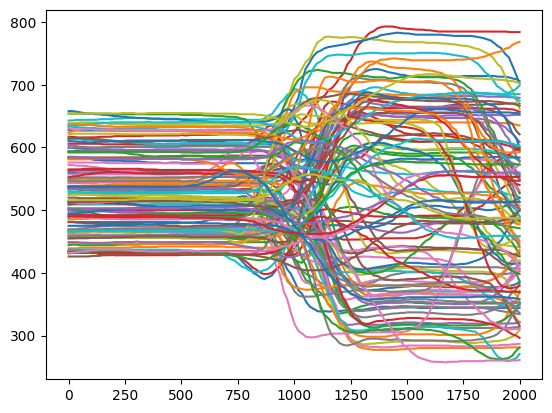

In [53]:
plt.plot(dataK[3])

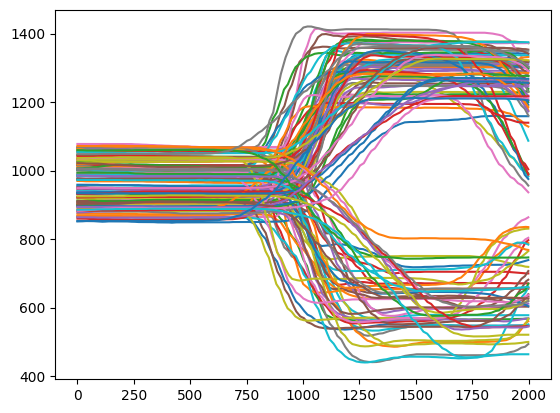

In [54]:
plt.plot(dataK[2])

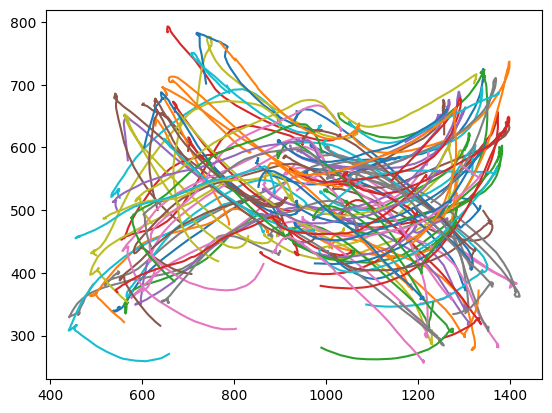

In [57]:
plt.plot(dataK[2], dataK[3])

In [43]:
data_tEtt= mat["tETT"]
print(len(data_tEtt))
print(type(data_tEtt)) 

111
<class 'numpy.ndarray'>


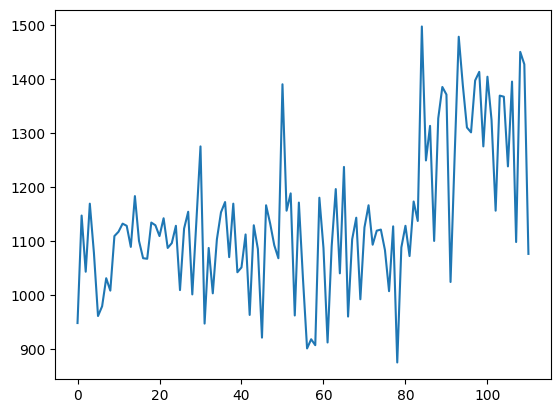

In [46]:
import matplotlib.pyplot as plt
plt.plot(data_tEtt)

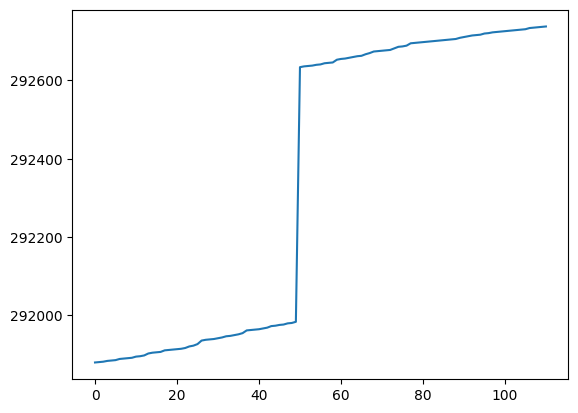

In [47]:
plt.plot(dataK[0][0])

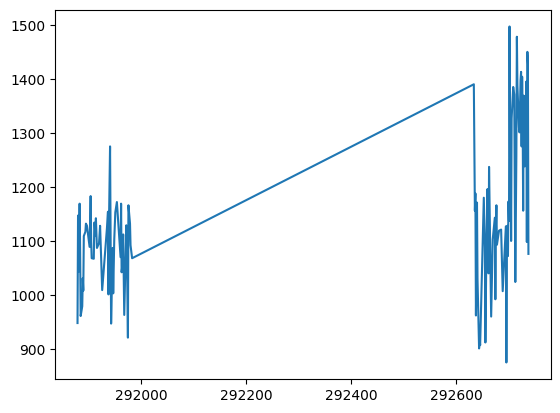

In [50]:
plt.plot(dataK[0][0], data_tEtt)

## Subject 27

Motivation may be: 
- 0: playing alone
- 1: easy rival
- 2: hard rival 

The data is now clustered by motivation level, i.e. `dataTrajecetories-25-M1-C1`. We are also splitting the dataset depending on the playing modes: passing through and stopping. For each dataset moreover we have the four different trajectories.

The data is normalized, clustered in terms of motivation, playing mode and ordered by trajectory. 

We seek to find a paramater fitting for each subject, motivational state and playing mode, and trajectory. Then we can consider the mean for each case to fit the model for each subject and motivational state. 

We consider the mass to be the same at the begining of the movement, hence we are studying 3 motivational states x 2 playing modes parameters per player. 

We have 4 possible trajectories (the playing modes just modify the control function, since the effort is different). 

In [70]:
import scipy
import os

path = 'myData-S27-1-C1.mat'

# Get the current directory
current_dir = os.getcwd()

# Navigate one step up (to the parent directory)
parent_dir = os.path.dirname(current_dir)

# Enter the 'data' folder
data_folder = os.path.join(parent_dir, 'data')

# Construct the full file path
full_path = os.path.join(data_folder, path)

# Load the data from the file
mat = scipy.io.loadmat(full_path)

In [71]:
# View the keys (variable names) in the .mat file
print(mat.keys())
mat 

dict_keys(['__header__', '__version__', '__globals__', 'dataK', 'tETT'])


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue May 14 17:30:33 2024',
 '__version__': '1.0',
 '__globals__': [],
 'dataK': array([[(array([[295009, 295011, 295013, 295014, 295015, 295017, 295018, 295020,
                 295021, 295023, 295024, 295025, 295027, 295028, 295029, 295030,
                 295032, 295033, 295034, 295035, 295036, 295038, 295039, 295041,
                 295043, 295045, 295046, 295047, 295048, 295049, 295050, 295051,
                 295052, 295053, 295054, 295055, 295057, 295058, 295059, 295060,
                 295061, 295062, 295063, 295064, 295065, 295066, 295067, 295068,
                 295069, 295070, 295071, 295072, 295073, 295074, 295077, 295078,
                 295080, 295081, 295082, 295083, 295084, 295085, 295086, 295087,
                 295090, 295091, 295092, 295093, 295094, 295095, 295096, 295097,
                 295098, 295099, 295100, 295101, 295102, 295103, 295104, 295105,
                 295106, 295107, 295108, 2

In [72]:
print('DataK:')
print(type(mat["dataK"]))
print(len(mat["dataK"]))
print('DataK [0]')
print(type(mat["dataK"][0]))
print(len(mat["dataK"][0]))
print('DataK [0][0]')
dataK = mat["dataK"][0][0] 
print(type(dataK))
print(len(dataK))
print(dataK)

# Extract the nested arrays within 'dataK'
#nested_array = mat["dataK"][0, 0]
#print(type(nested_array))

#dfx = pd.DataFrame(mat["dataK"])

DataK:
<class 'numpy.ndarray'>
1
DataK [0]
<class 'numpy.ndarray'>
1
DataK [0][0]
<class 'numpy.void'>
4
(array([[295009, 295011, 295013, 295014, 295015, 295017, 295018, 295020,
        295021, 295023, 295024, 295025, 295027, 295028, 295029, 295030,
        295032, 295033, 295034, 295035, 295036, 295038, 295039, 295041,
        295043, 295045, 295046, 295047, 295048, 295049, 295050, 295051,
        295052, 295053, 295054, 295055, 295057, 295058, 295059, 295060,
        295061, 295062, 295063, 295064, 295065, 295066, 295067, 295068,
        295069, 295070, 295071, 295072, 295073, 295074, 295077, 295078,
        295080, 295081, 295082, 295083, 295084, 295085, 295086, 295087,
        295090, 295091, 295092, 295093, 295094, 295095, 295096, 295097,
        295098, 295099, 295100, 295101, 295102, 295103, 295104, 295105,
        295106, 295107, 295108, 295109, 295110, 295111, 295112, 295113,
        295114, 295115, 295116, 295658, 295659, 295660, 295661, 295663,
        295664, 295665, 295667

In [34]:
print('DataK[0][0] [0]')
print(type(dataK[0]))
print(len(dataK[0]))
print(dataK[0])
print('DataK[0][0] [0][0]')
print(type(dataK[0][0]))
print(len(dataK[0][0]))
print(dataK[0][0])


DataK[0][0] [0]
<class 'numpy.ndarray'>
1
[[295009 295011 295013 295014 295015 295017 295018 295020 295021 295023
  295024 295025 295027 295028 295029 295030 295032 295033 295034 295035
  295036 295038 295039 295041 295043 295045 295046 295047 295048 295049
  295050 295051 295052 295053 295054 295055 295057 295058 295059 295060
  295061 295062 295063 295064 295065 295066 295067 295068 295069 295070
  295071 295072 295073 295074 295077 295078 295080 295081 295082 295083
  295084 295085 295086 295087 295090 295091 295092 295093 295094 295095
  295096 295097 295098 295099 295100 295101 295102 295103 295104 295105
  295106 295107 295108 295109 295110 295111 295112 295113 295114 295115
  295116 295658 295659 295660 295661 295663 295664 295665 295667 295668
  295670 295671 295673 295674 295675 295676 295677 295678 295679 295682
  295683 295684 295685 295686 295687 295688 295689 295690 295691 295692
  295694 295695 295697 295698 295699 295701 295703 295704 295706 295707
  295709 295710 295711

In [74]:
print('DataK[0][0] [0][0] [0]')
data_KK = dataK[0][0]
print(type(data_KK[0]))
print(data_KK[0])

DataK[0][0] [0][0] [0]
<class 'numpy.int32'>
295009


In [35]:
print('DataK[0][0] [1]')
print(type(dataK[1]))
print(len(dataK[1]))
print(dataK[1])

DataK[0][0] [1]
<class 'numpy.ndarray'>
2000
[[   1]
 [   2]
 [   3]
 ...
 [1998]
 [1999]
 [2000]]


In [36]:
print('DataK[0][0] [2]')
print(type(dataK[2]))
print(len(dataK[2]))
print(dataK[2])

DataK[0][0] [2]
<class 'numpy.ndarray'>
2000
[[ 998.375       883.          921.         ...  889.
   868.          866.        ]
 [ 998.3125      883.          921.         ...  889.
   868.05882353  866.        ]
 [ 998.25        883.          921.         ...  889.
   868.11764706  866.        ]
 ...
 [1325.73684211 1229.8125     1237.         ... 1218.
  1138.         1186.76470588]
 [1325.84210526 1229.875      1237.         ... 1218.
  1138.         1186.82352941]
 [1325.94736842 1229.9375     1237.         ... 1218.
  1138.         1186.88235294]]


In [37]:
print('DataK[0][0] [3]')
print(type(dataK[3]))
print(len(dataK[3]))
print(dataK[3])

DataK[0][0] [3]
<class 'numpy.ndarray'>
2000
[[607.625      492.         463.         ... 529.         469.
  540.        ]
 [607.6875     492.         463.         ... 529.         469.
  540.        ]
 [607.75       492.         463.         ... 529.         469.
  540.        ]
 ...
 [444.63157895 329.1875     320.         ... 386.         332.
  562.        ]
 [444.57894737 329.125      320.         ... 386.         332.
  562.        ]
 [444.52631579 329.0625     320.         ... 386.         332.
  562.        ]]


In [80]:
df__x = pd.DataFrame(dataK[2].T)
df__y = pd.DataFrame(dataK[3].T)

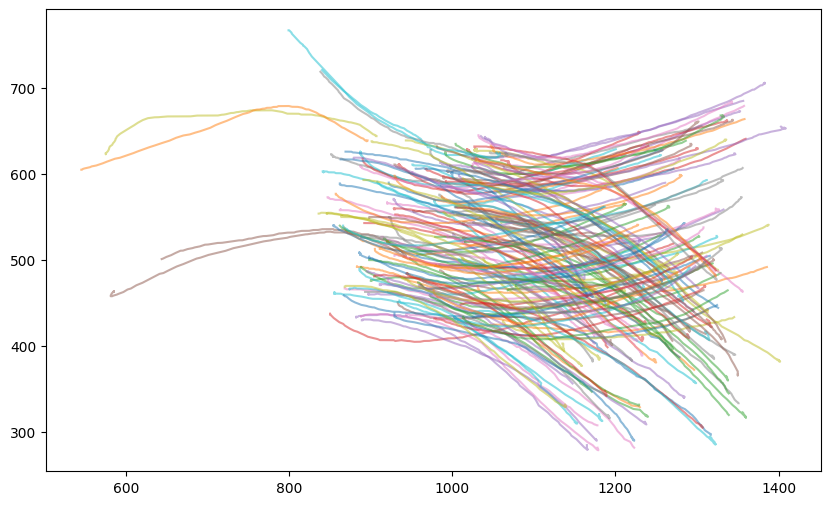

In [82]:
dfx = df__x.reset_index().drop(columns="index")
dfy = df__y.reset_index().drop(columns="index")
dfx = dfx.dropna()
dfy = dfy.dropna()

plt.figure(figsize=(10, 6))
for i in range(len(dfx)):
    plt.plot(dfx.iloc[i], dfy.iloc[i], alpha=0.5)
plt.show()

### Previous data

In [60]:
path = 'dataTrajectories-25.mat'

# Get the current directory
current_dir = os.getcwd()

# Navigate one step up (to the parent directory)
parent_dir = os.path.dirname(current_dir)

# Enter the 'data' folder
data_folder = os.path.join(parent_dir, 'data')

# Construct the full file path
full_path = os.path.join(data_folder, path)

# Load the data from the file
mat = scipy.io.loadmat(full_path)

In [61]:
# View the keys (variable names) in the .mat file
print(mat.keys())
mat

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Apr  9 18:17:44 2024',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ -0.344     ,   0.473     ,   0.387     , ...,          nan,
                  nan,          nan],
        [ -0.344     ,   0.473     ,   0.387     , ...,          nan,
                  nan,          nan],
        [ -0.344     ,   0.473     ,   0.387     , ...,          nan,
                  nan,          nan],
        ...,
        [ 12.9       ,  -3.12888235, -11.66311765, ...,          nan,
                  nan,          nan],
        [ 12.9       ,  -3.08841176, -11.66058824, ...,          nan,
                  nan,          nan],
        [ 12.9       ,  -3.04794118, -11.65805882, ...,          nan,
                  nan,          nan]]),
 'Y': array([[ 0.301     , -0.17452941,  0.172     , ...,         nan,
                 nan,         nan],
        [ 0.301     , -0.172     ,  0.172     , ...,         nan,
                 nan,

In [64]:
df_x = mat["X"].T
df_y = mat["Y"].T
print(len(df_x))
print(type(df_x))

1296
<class 'numpy.ndarray'>


In [67]:
print(type(df_x[0]))
print(len(df_x[0]))
print(df_x[0])
print(type(df_x[0][0]))

<class 'numpy.ndarray'>
2500
[-0.344 -0.344 -0.344 ... 12.9   12.9   12.9  ]
<class 'numpy.float64'>


 ...]

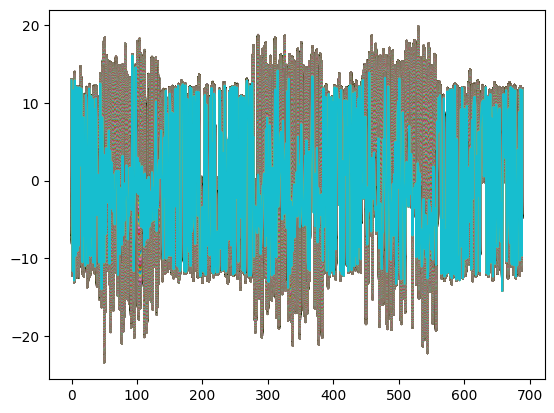

In [63]:
plt.plot(df_x)

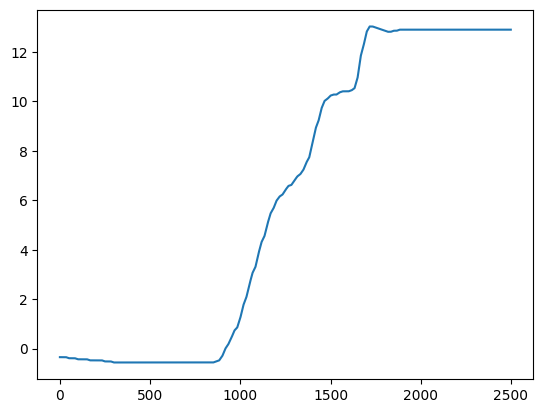

In [68]:
plt.plot(df_x[0])

In [75]:
dfx = pd.DataFrame(df_x)
dfy = pd.DataFrame(df_y)

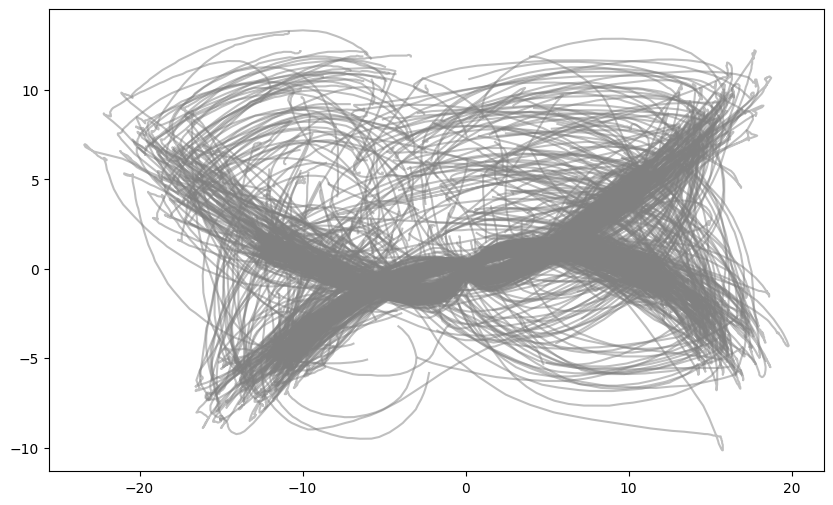

In [78]:
dfx = dfx.reset_index().drop(columns="index")
dfy = dfy.reset_index().drop(columns="index")
dfx = dfx.dropna()
dfy = dfy.dropna()

plt.figure(figsize=(10, 6))
for i in range(len(dfx)):
    plt.plot(dfx.iloc[i], dfy.iloc[i], color='gray', alpha=0.5)
plt.show()